# Building and Deploying a Sticker Sales Forecasting ML Solution with Modal

## Background

In January 2025, Kaggle ran a playground series [competition](https://www.kaggle.com/competitions/playground-series-s5e1/overview) to forecast multiple years' worth of sticker sales in different countries. For each id row, you have to predict the num_sold which represents the number of stickers sold for each type per store for each country.

This notebook walks through building and deploying a machine learning solution for forecasting sticker sales using [Modal](https://modal.com/) for serverless cloud computing. We'll cover the entire workflow from training to deployment.

NB: The data for this competition was synthentically generated but was made to contain real world patterns and effects that you might see in real data such as seasonality, weekend and holiday effect, etc.

In this project, we'll build an end-to-end solution for forecasting sticker sales across different stores and countries. We'll use:

- **FastAI**: For data preprocessing and model training.
- **Modal**: For serverless compute and API hosting

The solution will allow us to:
1. Train an XGBoost model to predict sticker sales
2. Use Modal for serverless deployment
3. Create an API endpoint for predictions
4. Visualize results with a Streamlit dashboard. After we are done deploying and serving our machine learning model, we build a UI for it using [streamlit](https://streamlit.io/), an open source framework that we can use to quickly build web applications.

Once we are done deploying our application, we can pass in our data for a single prediction or we can do batch prediction by passing in a csv file of the new data you want it will make predictions on. Our batch prediction app will look like below when we are done.

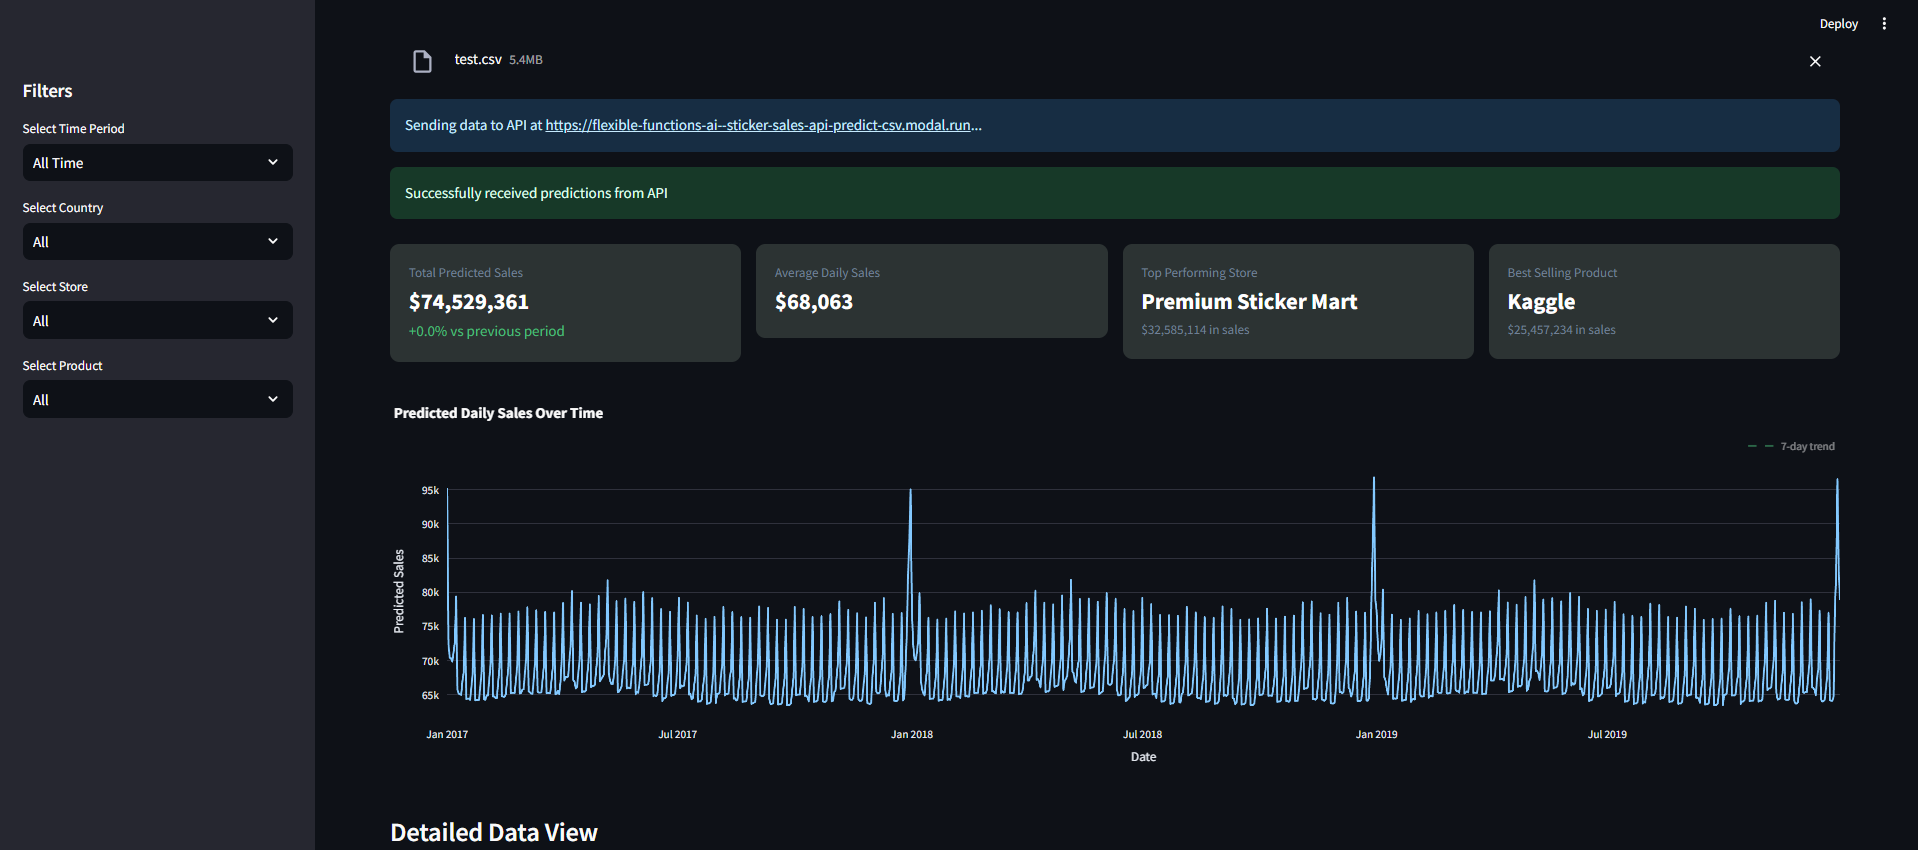


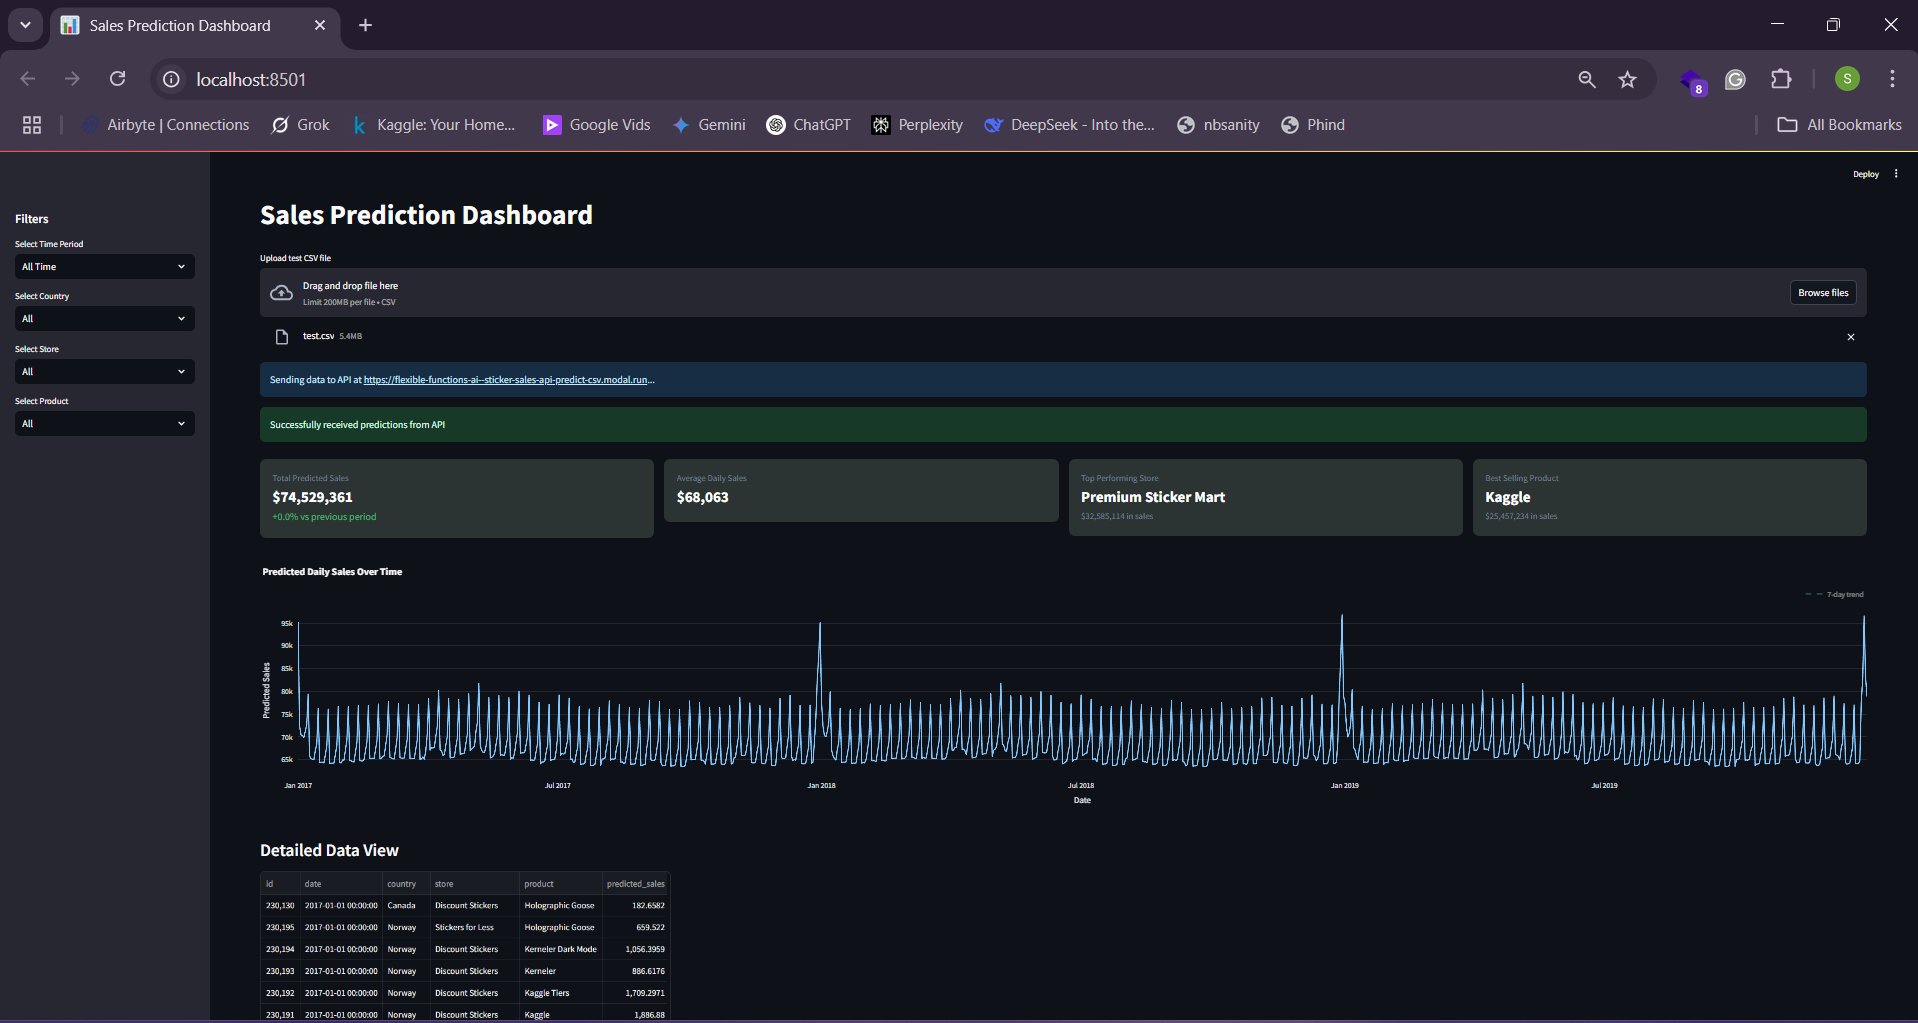

As you can see above, Once we pass in previously unseen data, our model returns new predictions for the number of stickers to be sold.

The competiton submission were evaluated on the [Mean Absolute Percentage Error (MAPE).](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) metric which expresses the average absolute error as a percentage of the actual values, making it easy to understand the relative size of errors For example, if you predict a value of 90 when the actual is 100, the percentage error is 10%, but if you predict 110 when the actual is 100, the percentage error is also 10%. MAPE averages these absolute percentage errors across all observations.

Let's get started!

## Model deployment and serving with [Modal](https://modal.com/). 

Modal is a serveless cloud platform that enables us to run and execute any python code in the cloud without having to manage infrastructure.Modal makes it easy to attach GPU'S with just one line of code and can serve our functions as web endpoints.

This makes deploying ML models simple with:

- Containerized environments defined in code
- Seamless scaling
- GPU support (when needed)
- Easy endpoint creation


I previously showed how to train, serve and deploy a machine learning model to a live API endpoint with bentoml and bentocloud [here](https://nbsanity.com/static/ac40bb062434c7446906d3eb8875e061/load.html). 

### Project Structure

Our project has this file organization:

```
retail_forecasting_model_deployment/
├── data/                           # Training and test data
├── bentofile.yaml                  # BentoML configuration
├── load_save.py                    # Local model training
├── modal_train.py                  # Modal model training
├── modal_upload.py                 # Upload data to Modal
├── modal_serve.py                  # Create API service with Modal
├── requirements.txt                # Dependencies
├── service.py                      # BentoML service definition
└── streamlit_ui/
    └── dashboard.py                # Streamlit dashboard
```

## Setting Up Your Environment

Let's start by setting up our environment. We start by logging into modal by running ```modal setup``` via our terminal. We then install the libraries we need for this project by running the below pip installations via your terminal.

In [1]:
#| code-fold: true
#| output: false
#| code-summary: "Library Installation"


%pip install catboost
#%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
%pip install polars
%pip install tqdm
#%pip install wandb
#%pip install sweetviz
#%pip install --upgrade scipy
%pip install gradio
%pip install dash
%pip install streamlit plotly requests
%pip install boto3
%pip install modal bentoml 
%pip install streamlit pandas requests plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

### Imports

In [ ]:
#|include: false 
#|hide_metadata
#| code-fold: true
#| output: false
#| code-summary: "Library Import"

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
#from fastkaggle import setup_comp
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.linear_model import LinearRegression

#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor,Pool, metrics, cv


import warnings


matplotlib.rc('image', cmap='Greys')
import scipy.stats as stats



#import h2o
#from h2o.automl import H2OAutoML

import gc
#import wandb

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

import dash
from dash import dcc, html, dash_table

import boto3
import io
import getpass
import json

from joblib import dump, load
import typing as t
import bentoml
from bentoml.validators import DataframeSchema

import modal

## Extract, Load and Transform

I use [airbyte](https://airbyte.com/) which is an open source tool that can be used to extract and load data from one source to another, building data pipelines.


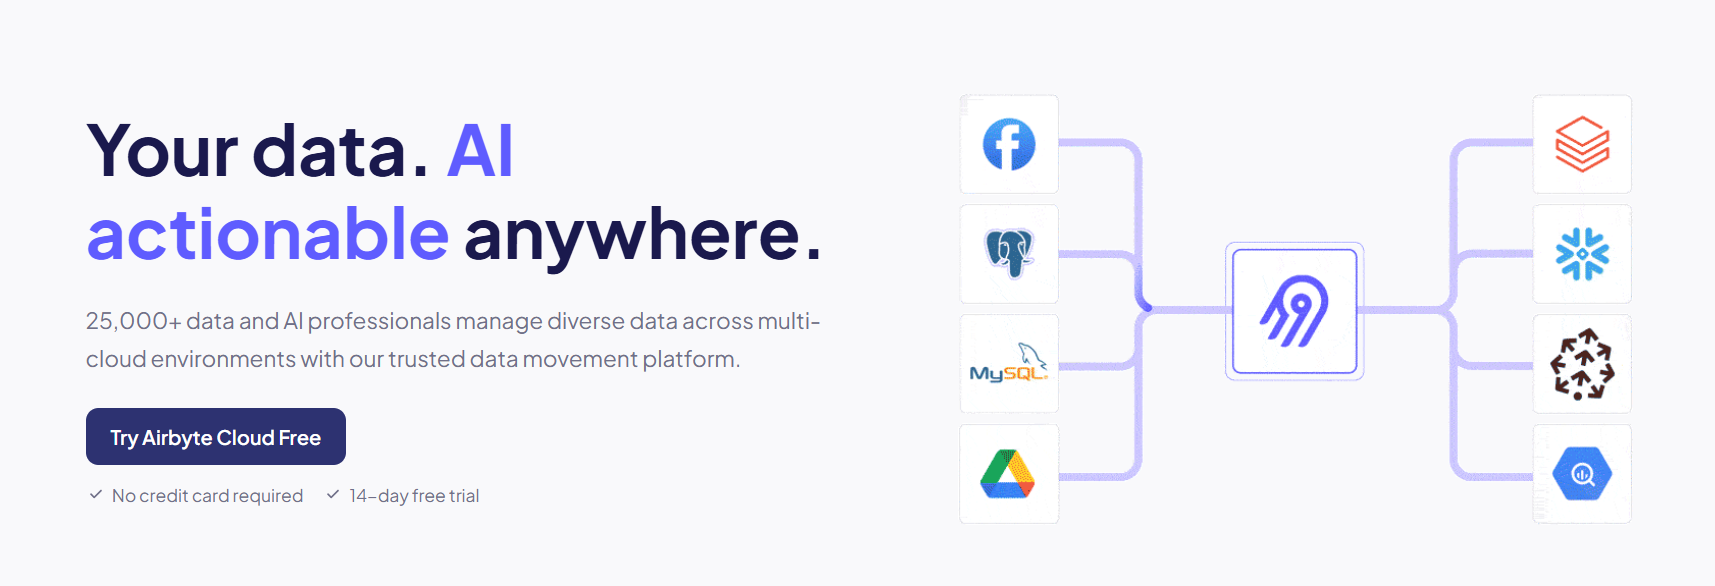


To demonstrate this in our example, we uploaded our training csv data into a google sheet and then pulled it aws s3. After this, we load this dataset into our training enviroment as shown below. Airbyte is well suited to handle this.

I do this to mirror how we would work with systems in real life, where data sources might be in different data sources such as ERP systems, spreadsheet software, social media apps, websites, etc. I show the whole process in this [video](https://drive.google.com/file/d/1oHN74oTUawj-WFLNgN8h2LqxzkWkEtrD/view?usp=sharing)

In [ ]:
#| include: false
#| code-fold: true
#| output: false
#| code-summary: "AWS Authentication"

# Get AWS credentials securely through interactive input
aws_access_key = input("Enter your AWS access key: ")
aws_secret_key = getpass.getpass("Enter your AWS secret key: ")

# Create S3 client with user-provided credentials
s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)

# Now you can use s3_client as before
# For example:
# response = s3_client.get_object(Bucket='your-bucket', Key='your-file.csv')
# df = pd.read_csv(io.BytesIO(response['Body'].read()))

In [ ]:
# Method 1: Download file to local and then read
#s3_client.download_file('flexible-functions', 'sticker-sales/train.csv/ss_train.csv', 'data/local_filename_ss.csv')
airbyte_df = pd.read_csv('data/local_filename_ss.csv')

Our data is in the _airbyte_data column, so lets go ahead and extract it. We have a few ways we can do this.

### Approach 1

In [ ]:
# Extract the JSON blobs from the '_airbyte_data' column
data = airbyte_df['_airbyte_data'].apply(json.loads)

# Convert the extracted JSON data into a DataFrame
extracted_df = pd.json_normalize(data)

# Save the extracted DataFrame to a CSV file in the data folder
extracted_df.to_csv("data/output.csv", index=False)
print("Data successfully extracted and saved to data/output.csv")

output_df = pd.read_csv('data/output.csv')
output_df.head()

### Approach 2 

We can load our data in a more optimal way. Lets do that below

In [ ]:
def transform_airbyte_data(input_file, output_file):
    """
    Transform Airbyte raw data format back to original tabular format
    
    Parameters:
    input_file (str): Path to the input file (CSV or JSON) from Airbyte
    output_file (str): Path to save the transformed CSV file
    
    Returns:
    pd.DataFrame: The transformed DataFrame
    """
    file_ext = os.path.splitext(input_file)[1].lower()
    
    # Read the data based on file type
    if file_ext == '.csv':
        df = pd.read_csv(input_file)
    elif file_ext == '.json':
        df = pd.read_json(input_file, lines=True)  # Assuming JSONL format
    else:
        raise ValueError(f"Unsupported file extension: {file_ext}. Use .csv or .json")
    
    # Check if the data is in Airbyte format
    airbyte_columns = [col for col in df.columns if col.startswith('_airbyte_')]
    
    if '_airbyte_data' in df.columns:
        # If *airbyte*data is a string column, parse it to dictionaries
        if df['_airbyte_data'].dtype == 'object' and isinstance(df['_airbyte_data'].iloc[0], str):
            df['_airbyte_data'] = df['_airbyte_data'].apply(json.loads)
        
        # Extract the data from *airbyte*data column
        extracted_data = pd.json_normalize(df['_airbyte_data'])
        
        # Convert numeric columns if needed
        for col in extracted_data.columns:
            if col in ['id', 'num_sold']:
                try:
                    extracted_data[col] = pd.to_numeric(extracted_data[col])
                except:
                    pass  # Keep as string if conversion fails
                    
        # Save the result
        extracted_data.to_csv(output_file, index=False)
        print(f"Transformed data saved to {output_file}")
        
        return extracted_data
    else:
        print("Data doesn't appear to be in Airbyte format. No transformation needed.")
        df.to_csv(output_file, index=False)
        return df

In [ ]:
# Example usage
if __name__ == "__main__":
    # Use paths in the data folder
    input_file = "data/local_filename_ss.csv"  # or .json
    output_file = "data/transformed_data.csv"
    
    transformed_df = transform_airbyte_data(input_file, output_file)
    transformed_df.head()

### Load data

We only did ELT job for the training dataset for demonstration, for the test and sample submission file, we shall load them from the local files.

In [ ]:
path = Path('')
path

In [ ]:
train_df = pd.read_csv(path/'data/transformed_data.csv',index_col='id')
test_df = pd.read_csv(path/'data/test.csv',index_col='id')
sub_df = pd.read_csv(path/'data/sample_submission.csv')

## Exploratory Data Analysis

In [ ]:
train_df.columns

In [ ]:
train_df.shape,test_df.shape

## Data Upload

We are now going to start by uploading our data to Modal using volumes. To quote the modal documentation

Modal Volumes provide a high-performance distributed file system for your Modal applications. They are designed for write-once, read-many I/O workloads, > like creating machine learning model weights and distributing them for inference.

This will enable our training function that we run later to access the data it will need to train our machine learning model.

NB: You can achieve the same data upload functionality using Modal Images by using the image.add_local_dir and image.add_local_file image builder methods. This can be done by creating an image that has our data like below
```
sticker_data_image = (
    modal.Image.debian_slim()
    .pip_install(["pandas", "numpy", "xgboost", "bentoml"])
    # Add your local data directory to the image
    .add_local_dir("./data", remote_path="/data")
)
```
For this example, I shall be uploading my data using Modal volumes as opposed to using images.

Navigate to your ```data_upload.py``` file and paste the below code which whose purpose we shall explain in detail.

In [ ]:
import modal
import sys
from pathlib import Path

# Create an app for the data upload (using App instead of Stub)
app = modal.App("sticker-data-upload")


Here we are initializing a Modal application named "sticker-data-upload". Modal is a cloud platform that lets you run Python functions in the cloud.

The App class is used to define a Modal application which is just a group of functions and classes that are deployed together.

In [ ]:
# Create a volume to persist data
volume = modal.Volume.from_name("sticker-data-volume", create_if_missing=True)

We then define our volume with ```modal.Volume.from_name``` which creates a persistent storage volume in Modal named ```sticker-data-volume```. The ```create_if_missing=True``` flag means it will create the volume if it doesn't already exist. Volumes in Modal are like shared disk space that can persist between function runs.

In [ ]:
#| code-fold: show
#| code-summary: "Modal Data Upload"

@app.function(volumes={"/data": volume})
def upload_data(local_data_path):
    import shutil
    import os
    
    # Ensure the destination directory exists
    os.makedirs("/data", exist_ok=True)
    
    # Copy all files from the local data directory to the volume
    for file in Path(local_data_path).glob("*"):
        dest = f"/data/{file.name}"
        if file.is_file():
            shutil.copy(file, dest)
            print(f"Copied {file} to {dest}")
    
    # List files to confirm upload
    print("\nFiles in Modal volume:")
    for file in Path("/data").glob("*"):
        print(f" - {file}")

@app.local_entrypoint()
def main():
    if len(sys.argv) > 1:
        data_path = sys.argv[1]
    else:
        data_path = "./data"  # Default path
    
    print(f"Uploading data from {data_path}")
    upload_data.remote(data_path)

Remember our modal app can consist of various functions and classes. To explicitly register an object with the app, we use the ```@app.function()``` decorator.Below we define functions to upload our data.

Inside the function, We import the necessary modules and ensure the destination directory exists. The ```exist_ok=True``` means it won't raise an error if the directory already exists.

I then loop through all files in the specified local directory, copy each file to the mounted volume at "/data", and print a confirmation message.
After copying, this lists all files in the volume to confirm they were uploaded successfully.

```@app.local_entrypoint()``` decorator, tells Modal that the main() function can be invoked directly from the command line using a command like ```modal run modal_upload.py``` allowing users to execute the ```main()``` function locally to initiate the app's workflow.

The ```@app.local_entrypoint()``` function in essence acts as a local orchestrator, initiating the remote execution of ```upload_data``` to upload files from the specified data_path to a Modal volume. It parses command-line arguments to determine the data path, prints a local message, and then triggers the actual data uploading process.

This ensures that the Modal App ```(app = modal.App("sticker-data-upload"))``` is automatically created and managed when the ```main()``` function is invoked via modal run. There’s no need to explicitly call ```app.run()```.

To upload the data, run ```python modal_upload.py ./data``` via the terminal to trigger the data upload.

## Model Training 

Next, we'll create a script to train our forecasting model. Navigate to your ```train.py``` file and paste the code in the below model training section whose code i shall explain. 

In [ ]:
#import modal
#import pandas as pd
#import numpy as np
#from fastai.tabular.all import *  # Move this import to the top level
#import xgboost as xgb
#import bentoml
#from pathlib import Path
#import os

# Define Modal resources
app = modal.App("sticker-sales-forecast")
image = modal.Image.debian_slim().pip_install([
    "fastai", 
    "xgboost", 
    "bentoml", 
    "scikit-learn", 
    "pandas", 
    "numpy", 
    "torch"
])
volume = modal.Volume.from_name("sticker-data-volume")

Above, we have a modal app called ```sticker-sales-forecast``` by running the above command. 

We then define an image which is a snapshot of our container's filesystem state. We can easily any third-party packages like ```torch```, ```pandas``` by passing in all the packages we need to the ```pip_install``` method of an image as shown above.

After defining our dependencies, we call and attach an existing volume called ```sticker-data-volume``` which we defined above in our training function. This contains the data needed for our model training in the ```train_model``` function defined below.

We define our ```@app.function``` decorator passing in our specified image and volume mounted at "/data".

In [ ]:
#| code-fold: show
#| code-summary: "Model Training Function" 

@app.function(image=image, volumes={"/data": volume})
def train_model():
    # No need to import fastai.tabular.all here since we moved it to the top
    
    # Set up paths
    path = Path('/data/')
    
    # Check if data files exist
    print("Files available in volume:")
    for file in path.glob("*"):
        print(f" - {file}")
    
    # Load data
    print("Loading data...")
    train_df = pd.read_csv(path/'train.csv', index_col='id')
    test_df = pd.read_csv(path/'test.csv', index_col='id')
    
    # Data preprocessing
    print("Preprocessing data...")
    train_df = train_df.dropna(subset=['num_sold'])
    train_df = add_datepart(train_df, 'date', drop=False)
    test_df = add_datepart(test_df, 'date', drop=False)
    
    # Feature preparation
    cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
    splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
    to = TabularPandas(train_df, procs=[Categorify, FillMissing, Normalize],
                      cat_names=cat_names,
                      cont_names=cont_names,
                      y_names='num_sold',
                      y_block=CategoryBlock(),
                      splits=splits)
    dls = to.dataloaders(bs=64)
    
    # Prepare training data
    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
    
    # Train XGBoost model
    print("Training XGBoost model...")
    xgb_model = xgb.XGBRegressor()
    xgb_model = xgb_model.fit(X_train, y_train)
    
    # Save model with BentoML
    print("Saving model with BentoML...")
    model_tag = bentoml.xgboost.save_model(
        "sticker_sales_v1", 
        xgb_model,
        custom_objects={
            "preprocessor": {
                "cont_names": cont_names,
                "cat_names": cat_names
            }
        }
    )
    
    print(f"Model saved: {model_tag}")
    return str(model_tag)


In our script above, after setting up the paths and loading the training and test data into their respective data frames, ```train_df``` and ```test_df```, We define the preprocessing steps to be taken on our datasets. 

Our first preprocessing step is to use the [```add_datepart```](https://docs.fast.ai/tabular.core.html#add_datepart) helper function from [fast.ai](https://docs.fast.ai/) to add columns/features relevant to the date column in a data frame if available. This is defined using ``` add_datepart (df, field_name, prefix=None, drop=True, time=False)```. 

For example, if we have a date column with a row that has '2019-12-04'. We can generate new columns such as Year, Month, Day, Dayofweek, Is_month_start, 	Is_quarter_end, etc.

Our next step is to do the below stated basic fastai tabular preprocessing. 

- First, we define categorical and continuous variables, I use the fastai [cont_cat_split](https://docs.fast.ai/tabular.core.html#cont_cat_split) function to separate my dataset variables into categorical and continuous variables based of the cardinality of my column values.

We take an argument max card whose default is 20. If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continuous and vice versa.

- Split into training and validation set. The [RandomSplitter](https://docs.fast.ai/data.transforms.html#randomsplitter) function above separates the training set into a training and validation set based on the value of the argument valid_pct.

- I use fastai's TabularPandas class to create a TabularPandas object that applies preprocessing steps to our data, creating a data frame wrapper that takes in different arguments and knows which columns are categorical and continuous. I also define the target variable, y_name, the type of target and problem we are dealing with, and the way to split our data which was previously defined in the ```splits``` above.

I then define a list of preprocessing steps, Procs, to be taken on our data.

Categorify deals with the categorical variables and converts each category into a list of indexable numerical integers, creating numerical input which is required by our model. Each category corresponds to a different number.

FillMissing as its name suggests, fills in the missing values in columns with continuous values. This can be filled in with the median, mode of that column, or a constant, with the default being the median value for that particular column. As said above, FillMissing supports using the mode and a constant as strategies for dealing with missing values. We can do this by changing the FillMissing argument fill_strategy to mode or constant.

Normalize puts the continuous variables between a standardized scale without losing important information by subtracting the mean and dividing by the standard deviation.

- I then define a DataLoader which is an extension of PyTorch's DataLoaders class albeit with more functionality. This takes in our data above from the TabularPandas object and prepares it as input for our model passing it in batches which we defined by our batch size set by the bs argument.

The DataLoaders and TabularPandas Object allow us to build data objects we can use for training without specifically changing the raw input data.

The dataloader then acts as input for our models.

- In order to use other libraries with fastai, I extract the x's and y's from my TabularPandas object which I used to preprocess the data.
I can now directly use the training and validation set values I extracted above as direct input for decision trees and gradient boosting models.

An instance of XGBRegressor is then created with default parameters, and a model is trained by calling .fit() with the training features (X_train) and target values (y_train). The model is finally serialized and saved to the bentoML model store. 


#### Entry Point

We now define our entry point. As explained before the ```@app.local_entrypoint()``` decorator, declared below makes this function the entry point when you run the script locally via ```train_model.remote()``` executes the training function in Modal's cloud

```
@app.local_entrypoint()
def main():
    # Train the model remotely
    print("Starting model training on Modal...")
    model_tag = train_model.remote()
    print(f"Model training completed. Model tag: {model_tag}")
```

The ```@app.local_entrypoint()``` decorator declared below makes this function the entry point.

In [ ]:
@app.local_entrypoint()
def main():
    # Train the model remotely
    print("Starting model training on Modal...")
    model_tag = train_model.remote()
    print(f"Model training completed. Model tag: {model_tag}")

Now run ```python modal_train.py``` via the command line to trigger the machine learning model training and saving via modal cloud. After this, we can proceed to deploy and serve our trained machin learning model.

To do this, navigate to the ```serve.py``` file and paste all the code in the below model serving and deployment section.

## Trained model serving and deployment

Just like before, We create a Modal App called "sticker-sales-api" which acts as the container for all the functions that will be deployed.

In [ ]:
#import modal
#import pandas as pd
#import numpy as np
#from fastapi import File, UploadFile, Form, HTTPException
#import io

# Create app definition
app = modal.App("sticker-sales-api")

# Define base image with all dependencies
base_image = (modal.Image.debian_slim()
         .pip_install("pydantic==1.10.8")        
         .pip_install("fastapi==0.95.2")         
         .pip_install("uvicorn==0.22.0")         
         .pip_install("bentoml==1.3.2")          
         .pip_install([                         
             "xgboost==1.7.6",
             "scikit-learn==1.3.1",
             "pandas",
             "numpy",
         ]))

# Create the fastai image by extending the base image
fastai_image = (base_image
                .pip_install(["fastai", "torch"]))

We then go ahead and define two separate container images.

The main image,```base_image``` includes dependencies for the API (FastAPI, pydantic, uvicorn) plus modal-related packages (BentoML, XGBoost, scikit-learn).
A separate ```fastai_image``` is created to avoid dependency conflicts, as FastAI has specific requirements for torch and other packages.

In [ ]:
# Create volume to access data
data_volume = modal.Volume.from_name("sticker-data-volume")

Just like before, we call and attach an exisiting volume called ```sticker-data-volume```.

In [ ]:
# Simple health endpoint
@app.function(image=base_image)
@modal.fastapi_endpoint(method="GET")
def health():
    """Health check endpoint to verify the API is running"""
    return {"status": "healthy", "service": "sticker-sales-api"}

We define a health endpoint to provide a simple way to check if our API service is alive and functioning correctly. We can use this to verify our service is available without needing to test the full prediction functionality.

In [ ]:
#| code-fold: show
#| code-summary: "Modal Data Upload"

# Function to train and save model - this is a direct function without any BentoML
@app.function(image=fastai_image, volumes={"/data": data_volume})
def train_xgboost_model():
    """Train an XGBoost model and return it directly"""
    import xgboost as xgb
    from fastai.tabular.all import add_datepart, TabularPandas, cont_cat_split
    from fastai.tabular.all import Categorify, FillMissing, Normalize, CategoryBlock, RandomSplitter, range_of
    from pathlib import Path
    import pickle
    import os
    
    # Create a path to save the model for future use
    model_path = "/data/sticker_sales_model.pkl"
    
    # Check if model already exists
    if os.path.exists(model_path):
        print(f"Loading existing model from {model_path}")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        return model
    
    try:
        print("Training new model...")
        # Load and preprocess training data
        path = Path('/data/')
        
        print("Loading training data...")
        train_df = pd.read_csv(path/'train.csv', index_col='id')
        
        # Drop rows with missing target values
        train_df = train_df.dropna(subset=['num_sold'])
        
        # Add date features
        print("Preprocessing data...")
        train_df = add_datepart(train_df, 'date', drop=False)
        
        # Feature preparation
        cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
        splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
        
        # Create TabularPandas processor
        to = TabularPandas(train_df, 
                          procs=[Categorify, FillMissing, Normalize],
                          cat_names=cat_names,
                          cont_names=cont_names,
                          y_names='num_sold',
                          y_block=CategoryBlock(),
                          splits=splits)
        
        # Prepare training data
        X_train, y_train = to.train.xs, to.train.ys.values.ravel()
        
        # Train a simple XGBoost model
        print("Training XGBoost model...")
        xgb_model = xgb.XGBRegressor(n_estimators=100)
        xgb_model.fit(X_train, y_train)
        
        # Save model to file
        print(f"Saving model to {model_path}")
        with open(model_path, 'wb') as f:
            pickle.dump(xgb_model, f)
        
        print("Model training complete!")
        return xgb_model
        
    except Exception as e:
        import traceback
        print(f"Error training model: {str(e)}")
        print(traceback.format_exc())
        raise

Above we define a function ```train_xgboost_model```. This is a fallback mechanism built into the serving API that first checks if a model exists at a specific path on the volume.

If found, it loads the existing model; if not, it trains a new one. This ensures the API endpoint can always return predictions, even if the scheduled training hasn't run yet.

In [ ]:

# CSV upload endpoint 
@app.function(image=fastai_image, volumes={"/data": data_volume})
@modal.fastapi_endpoint(method="POST")
async def predict_csv(file: UploadFile = File(...)):
    """API endpoint for batch predictions from a CSV file"""
    import xgboost as xgb
    import io
    import pickle
    from fastai.tabular.all import add_datepart, TabularPandas, cont_cat_split
    from fastai.tabular.all import Categorify, FillMissing, Normalize, CategoryBlock, RandomSplitter, range_of
    from pathlib import Path
    
    try:
        # First, train or load model
        model = train_xgboost_model.remote()
        
        # Read uploaded CSV file content
        contents = await file.read()
        
        # Parse CSV data
        try:
            test_df = pd.read_csv(io.BytesIO(contents))
        except Exception as e:
            return {
                "success": False,
                "error": f"Failed to parse uploaded CSV: {str(e)}"
            }
        
        # Load the training data for preprocessing
        path = Path('/data/')
        train_df = pd.read_csv(path/'train.csv', index_col='id')
        train_df = train_df.dropna(subset=['num_sold'])
        
        # Add date features to both datasets
        train_df = add_datepart(train_df, 'date', drop=False)
        test_df = add_datepart(test_df, 'date', drop=False)
        
        # Feature preparation
        cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
        splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
        
        # Create TabularPandas processor
        to = TabularPandas(train_df, 
                          procs=[Categorify, FillMissing, Normalize],
                          cat_names=cat_names,
                          cont_names=cont_names,
                          y_names='num_sold',
                          y_block=CategoryBlock(),
                          splits=splits)
        
        # Create a test dataloader
        dls = to.dataloaders(bs=64)
        test_dl = dls.test_dl(test_df)
        
        # Make predictions using our model
        predictions = model.predict(test_dl.xs)
        
        # Return the predictions as a simple list
        return predictions.tolist()
            
    except Exception as e:
        import traceback
        return {
            "success": False,
            "error": f"Error processing CSV: {str(e)}",
            "traceback": traceback.format_exc()
        }

In [ ]:

@app.local_entrypoint()
def main():
    """Local entrypoint for testing the API"""
    print("Starting sticker-sales-api...")
    
    # Pre-train the model to ensure it exists
    print("Training model...")
    train_xgboost_model.remote()
    print("Model training complete!")
    
    print("\nAPI is ready for use at:")
    print("- Health check: https://flexible-functions-ai--sticker-sales-api-health.modal.run")
    print("- CSV predictions: https://flexible-functions-ai--sticker-sales-api-predict-csv.modal.run")

## Testing API Endpoints

Let's create a simple script to test our deployed endpoints:

```python
import requests
import json

# Your Modal API URLs (replace with your actual endpoint URLs)
HEALTH_URL = "https://flexible-functions-ai--sticker-sales-api-health.modal.run"
PREDICT_URL = "https://flexible-functions-ai--sticker-sales-api-predict-csv.modal.run"

def test_health():
    """Test the health endpoint"""
    print("\n🔍 Testing health endpoint...")
    try:
        response = requests.get(HEALTH_URL)
        if response.status_code == 200:
            print("✅ Health check successful!")
            print(f"Response: {response.json()}")
        else:
            print(f"❌ Health check failed with status code: {response.status_code}")
            print(f"Response: {response.text}")
    except Exception as e:
        print(f"❌ Error connecting to health endpoint: {e}")

def test_prediction():
    """Test the prediction endpoint with a sample CSV"""
    print("\n🔍 Testing prediction endpoint...")
    
    # Use the sample test.csv file
    try:
        files = {'file': open('data/test.csv', 'rb')}
        response = requests.post(PREDICT_URL, files=files)
        
        if response.status_code == 200:
            predictions = response.json()
            print("✅ Prediction successful!")
            print(f"Received {len(predictions)} predictions")
            print(f"First 5 predictions: {predictions[:5]}")
        else:
            print(f"❌ Prediction failed with status code: {response.status_code}")
            print(f"Response: {response.text}")
    except Exception as e:
        print(f"❌ Error connecting to prediction endpoint: {e}")

if __name__ == "__main__":
    print("=== Modal API Test ===")
    test_health()
    test_prediction()
    print("\n=== Test Complete ===")
```

## Building a Streamlit Dashboard

Finally, let's create a Streamlit dashboard to visualize our predictions:

```python
import streamlit as st
import pandas as pd
import requests
import plotly.express as px
from datetime import datetime

def load_and_predict_data(csv_path):
    """
    Sends the test CSV to the BentoML API endpoint and gets predictions
    """
    # Making a POST request to the prediction endpoint
    files = {'file': open(csv_path, 'rb')}
    response = requests.post(
        "https://flexible-functions-ai--sticker-sales-api-predict-csv.modal.run",
        files=files
    )
    predictions = response.json()
   
    # Load the original test data
    test_df = pd.read_csv(csv_path)
   
    # Add predictions to the dataframe
    test_df['predicted_sales'] = predictions
   
    # Convert date column to datetime
    test_df['date'] = pd.to_datetime(test_df['date'])
   
    return test_df

def create_dashboard():
    """
    Creates the Streamlit dashboard with enhanced filters, KPI cards, and visualizations
    """
    st.title("Sticker Sales Prediction Dashboard")
    
    # File uploader for the test CSV
    uploaded_file = st.file_uploader("Upload test CSV file", type=['csv'])
    
    if uploaded_file is not None:
        # Save the uploaded file temporarily
        with open('temp_test.csv', 'wb') as f:
            f.write(uploaded_file.getvalue())
        
        # Load data and get predictions
        df = load_and_predict_data('temp_test.csv')
        
        # Creating filters in a sidebar
        st.sidebar.header("Filters")
        
        # Time period filter
        time_periods = {
            'All Time': None,
            'Last Month': 30,
            'Last 3 Months': 90,
            'Last Year': 365
        }
        selected_period = st.sidebar.selectbox('Select Time Period', list(time_periods.keys()))
        
        # Country filter
        countries = ['All'] + sorted(df['country'].unique().tolist())
        selected_country = st.sidebar.selectbox('Select Country', countries)
        
        # Store filter
        stores = ['All'] + sorted(df['store'].unique().tolist())
        selected_store = st.sidebar.selectbox('Select Store', stores)
        
        # Product filter
        products = ['All'] + sorted(df['product'].unique().tolist())
        selected_product = st.sidebar.selectbox('Select Product', products)
        
        # Apply filters
        filtered_df = df.copy()
        
        # Apply time filter
        if time_periods[selected_period]:
            max_date = filtered_df['date'].max()
            cutoff_date = max_date - pd.Timedelta(days=time_periods[selected_period])
            filtered_df = filtered_df[filtered_df['date'] >= cutoff_date]
        
        if selected_country != 'All':
            filtered_df = filtered_df[filtered_df['country'] == selected_country]
        if selected_store != 'All':
            filtered_df = filtered_df[filtered_df['store'] == selected_store]
        if selected_product != 'All':
            filtered_df = filtered_df[filtered_df['product'] == selected_product]
        
        # Calculate metrics for KPI cards
        total_sales = filtered_df['predicted_sales'].sum()
        avg_daily_sales = filtered_df.groupby('date')['predicted_sales'].sum().mean()
        
        # Create KPI cards using columns
        col1, col2 = st.columns(2)
        
        with col1:
            st.metric("Total Predicted Sales", f"${total_sales:,.0f}")
            
        with col2:
            st.metric("Average Daily Sales", f"${avg_daily_sales:,.0f}")
        
        # Group by date and calculate daily total predicted sales
        daily_sales = filtered_df.groupby('date')['predicted_sales'].sum().reset_index()
        
        # Create the line chart using Plotly
        fig = px.line(
            daily_sales,
            x='date',
            y='predicted_sales',
            title='Predicted Daily Sales Over Time'
        )
        
        # Display the plot
        st.plotly_chart(fig, use_container_width=True)
        
        # Display detailed data view
        st.subheader("Detailed Data View")
        st.dataframe(
            filtered_df[['date', 'country', 'store', 'product', 'predicted_sales']].sort_values('date'),
            hide_index=True
        )

if __name__ == "__main__":
    # Set page configuration
    st.set_page_config(
        page_title="Sales Prediction Dashboard",
        page_icon="📊",
        layout="wide",
        initial_sidebar_state="expanded"
    )
    create_dashboard()
```

##  Deploying the Streamlit Dashboard

To deploy the Streamlit dashboard:

```bash
# Navigate to the streamlit_ui directory
cd streamlit_ui

# Run the Streamlit app
streamlit run dashboard.py
```

## Running the Entire Pipeline

Here's how to run the entire pipeline:

1. Upload data to Modal:
```bash
python modal_upload.py data/
```

2. Train the model on Modal:
```bash
python modal_train.py
```

3. Deploy the API on Modal:
```bash
python modal_serve.py
```

4. Run the Streamlit dashboard:
```bash
cd streamlit_ui
streamlit run dashboard.py
```

## Key Benefits of This Approach

1. **Serverless Training and Deployment**: Modal handles all infrastructure, scaling, and container management.

2. **Production-Ready API**: The API is automatically served with proper endpoints, error handling, and authentication.

3. **Separation of Concerns**: Data preprocessing, model training, and serving are cleanly separated.

4. **Interactive Dashboard**: Stakeholders can visualize predictions without technical knowledge.

5. **Reproducibility**: The entire pipeline is defined in code, making it easy to reproduce.

## Improvements

Adding feature store - I shall be adding a feature store in v2 of this blog. This will help with Consistent feature engineering and avoid duplicating the same processing logic in different scripts etc.

## Conclusion

In this notebook, we've built an end-to-end machine learning system for forecasting sticker sales. We've used Modal to train and deploy our model, FastAI for preprocessing, XGBoost for prediction, and Streamlit for visualization.

This approach demonstrates how modern tools can simplify the MLOps process, reducing the overhead involved in deploying machine learning solutions to production.